<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch4_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Integration (quadrature): Newton-Cotes formulas
e.g., Trapezoidal rule, Simpson's rule

Trapezoidal rule is the "swiss army knife" of quadrature rules (using the language of Driscoll and Braun)

**Learning objectives**
- Learn how to implement **non-composite** Newton-Cotes formulas, in particular the **closed** versions
- See the connection between exact integration of the interpolating polynomial

**Contents**
- For a fixed function $f(x)$ and $I=\int_a^b f(x)\,dx$, we'll plot the various approximations for different values of $n=1,2,\ldots,6$
- Then we'll loop over several different functions $f$ and look at how the error decays as $n$ increases. Do we have similar behavior for all functions $f$?

**Going further**
- See also Prof. Brown's [integration notebook](https://github.com/cu-numcomp/numcomp-class/blob/master/Integration.ipynb) for CSCI-3656   [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cu-numcomp/numcomp-class/blob/master/Integration.ipynb)
- Bengt Fornberg's talk [Gregory formulas and improving on the Trapezoidal rule](https://www.colorado.edu/amath/sites/default/files/attached-files/2019_unm_0.pdf)

Copyright 2025 Department of Applied Mathematics, University of Colorado Boulder
Released under a BSD 3-clause license

## Setup
Newton-Cotes assumes we have $n+1$ equispaced nodes.  Given an interval $[a,b]$, the only thing that matters is $b-a$ (which will affect the distance between nodes, $h=(b-a)/n$). The absolute location of $a$ and $b$ does not affect the *formula* (of course, it does affect which nodes we evaluate the function at).

So, for a given $n$, we can derive the *formula* once-and-for all, and then just apply it. In fact, we don't derive it ourselves because it was derived for us hundreds of years ago. So we just look it up in a table:

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BarycentricInterpolator as interp
from numpy.polynomial import Polynomial as P

# From Table 9.2 in Quarteroni, Sacco and Saleri "Numerical Mathematics" (Springer, 2000)
ClosedNewtonCotesWeights = { 1:[1/2,1/2], 2:[1/3,4/3,1/3], 3:[3/8,9/8,9/8,3/8], 4:[14/45, 64/45, 24/45, 64/45, 14/45],
    5:[95/288, 375/288,250/288, 250/288, 375/288, 95/288], 6:[41/140,216/140,27/140,272/140,27/140,216/140,41/140]}
ClosedNewtonCotesNames = {1:"n=1, Trapezoid", 2:"n=2, Simpson's", 3:"n=3, Simpson's 3/8", 4:"n=4, Boole's", 5:"n=5", 6:"n=6"}

## Let's pick a function to integrate
Since this is an academic example, we'll pick a function with a known antiderivative, so that we can check our error

Integral I is 1.751


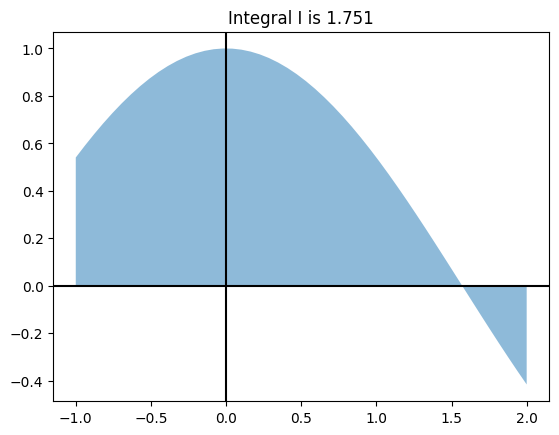

In [46]:
f = lambda x : np.cos(x)
F = lambda x : np.sin(x)  # dF/dx = f
a,b = -1,2


# Other examples to try
# f = lambda x : x**(3/2)
# F = lambda x : 2/5*x**(5/2)
# a,b = 0,1

# f = lambda x : 1/(1+x**2)  # aka Runge's function
# F = lambda x : np.arctan(x)
# a,b = -5,5

I   = F(b) - F(a)
print(f"Integral I is {I:.3f}")

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5)
plt.axvline(color='k')
plt.axhline(color='k')
plt.title(f"Integral I is {I:.3f}")
plt.show()

### Try the Trapezoidal rule, $n = 1$
Recall: we always have $n+1$ nodes

Closed formulas include the end points, so the spacing is $h=(b-a)/n$, whereas open formulas have "ghost nodes" at the end points, so the spacing is $h=(b-a)/(n+2)$

Using the rule:  n=1, Trapezoid with weights  [0.5, 0.5]
True integral: 1.751, Estimate: 0.186, Abs. Error: 1.56454


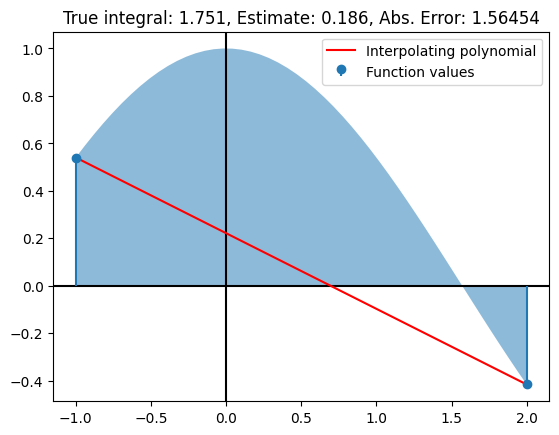

In [47]:
n = 1
weights   = ClosedNewtonCotesWeights[n]
print("Using the rule: ", ClosedNewtonCotesNames[n], 'with weights ', weights )
# By default, linspace includes end points, so it gives us "closed" nodes
nodes,h = np.linspace(a,b,n+1,retstep=True) # retstep tells it to return the spacing h

I_n = h*np.dot( weights, f(nodes) ) # implementing the trapezoidal rule is easy
p   = interp(nodes,f(nodes))

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');
plt.plot( x, p(x), 'r-', label="Interpolating polynomial" )
plt.stem( nodes, f(nodes), basefmt=' ', label="Function values" )
print(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.title(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.legend()
plt.show()


#### ... but here's the conceptual way to think about it:
We interpolate with a polynomial of degree $n$ (this is unique), then integrate that polynomial exactly (easy, since it's a polynomial)

And to be even lazier, numpy's builtin Polynomial class does the integration for us! (the BarycentricInterpolator doesn't do this for us, which is why we switch to the numpy Polynomial class now):

In [61]:
p = P.fit(nodes,f(nodes),deg=n) # interpolation (really, least-squares, but 0 residual since degree is large enough)
antideriv = p.integ(lbnd=a)
antideriv(b),  I_n

(np.float64(0.1862332039814959), np.float64(0.18623320398149604))

### And Simpson's rule, $n=2$

Using the rule:  n=2, Simpson's with weights  [0.3333333333333333, 1.3333333333333333, 0.3333333333333333]
True integral: 1.751, Estimate: 1.817, Abs. Error: 0.06647


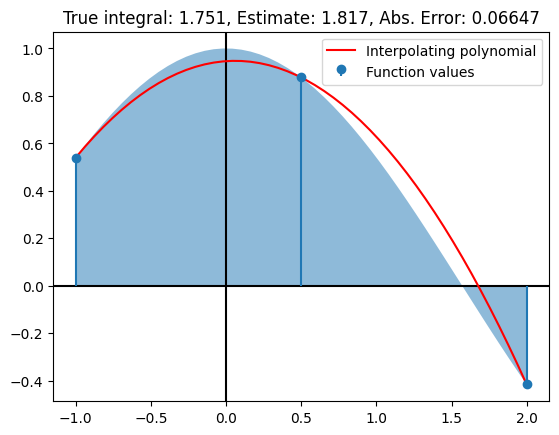

In [62]:
n = 2
weights   = ClosedNewtonCotesWeights[n]
print("Using the rule: ", ClosedNewtonCotesNames[n], 'with weights ', weights )
nodes,h = np.linspace(a,b,n+1,retstep=True) # retstep tells it to return the spacing h

I_n = h*np.dot( weights, f(nodes) )
p   = interp(nodes,f(nodes))

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');
plt.plot( x, p(x), 'r-', label="Interpolating polynomial" )
plt.legend()
plt.stem( nodes, f(nodes), basefmt=' ', label="Function values" )
print(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.title(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.legend()
plt.show()

#### and again, the alternative way to think of it:

In [63]:
p = P.fit(nodes,f(nodes),deg=n) # interpolation (really, least-squares, but 0 residual since degree is large enough)
antideriv = p.integ(lbnd=a)
antideriv(b),  I_n

(np.float64(1.817242858441245), np.float64(1.8172428584412441))

### $n=3$, sometimes called Simpson's 3/8 rule

Using the rule:  n=3, Simpson's 3/8 with weights  [0.375, 1.125, 1.125, 0.375]
True integral: 1.751, Estimate: 1.779, Abs. Error: 0.02863


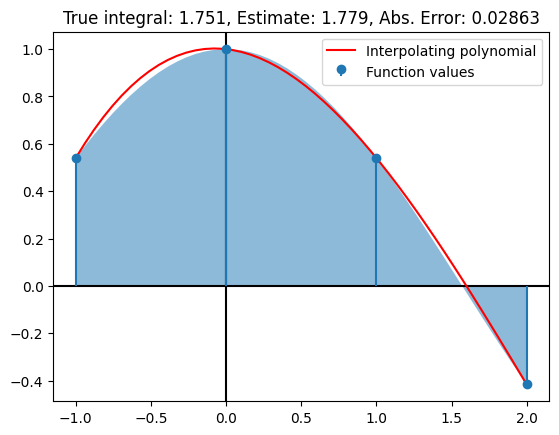

In [64]:
n = 3
weights   = ClosedNewtonCotesWeights[n]
print("Using the rule: ", ClosedNewtonCotesNames[n], 'with weights ', weights )
(nodes,h) = np.linspace(a,b,n+1,retstep=True) # retstep tells it to return the spacing h

I_n = h*np.dot( weights, f(nodes) )
p   = interp(nodes,f(nodes))

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');
plt.plot( x, p(x), 'r-', label="Interpolating polynomial" )
plt.stem( nodes, f(nodes), basefmt=' ', label="Function values" )
print(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.title(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.legend()
plt.show()

In [65]:
p = P.fit(nodes,f(nodes),deg=n) # interpolation (really, least-squares, but 0 residual since degree is large enough)
antideriv = p.integ(lbnd=a)
antideriv(b),  I_n

(np.float64(1.7793983950970302), np.float64(1.7793983950970311))

### $n=4$, "Boole's rule"

Using the rule:  n=4, Boole's with weights  [0.3111111111111111, 1.4222222222222223, 0.5333333333333333, 1.4222222222222223, 0.3111111111111111]
True integral: 1.751, Estimate: 1.750, Abs. Error: 0.00092


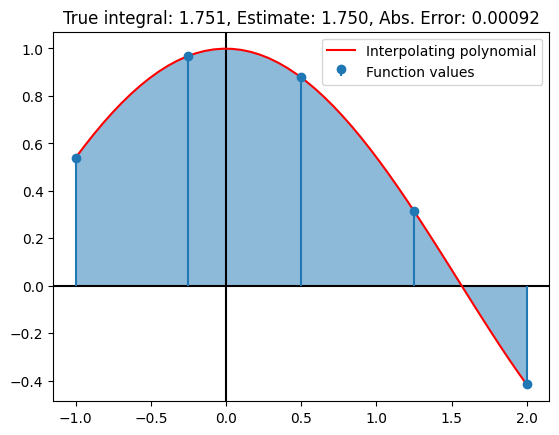

In [66]:
n = 4
weights   = ClosedNewtonCotesWeights[n]
print("Using the rule: ", ClosedNewtonCotesNames[n], 'with weights ', weights )
(nodes,h) = np.linspace(a,b,n+1,retstep=True) # retstep tells it to return the spacing h

I_n = h*np.dot( weights, f(nodes) )
p   = interp(nodes,f(nodes))

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');
plt.plot( x, p(x), 'r-', label="Interpolating polynomial" )
plt.stem( nodes, f(nodes), basefmt=' ', label="Function values" )
print(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.title(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.legend()
plt.show()

In [67]:
p = P.fit(nodes,f(nodes),deg=n) # interpolation (really, least-squares, but 0 residual since degree is large enough)
antideriv = p.integ(lbnd=a)
antideriv(b),  I_n

(np.float64(1.7498530706440212), np.float64(1.749853070644023))

### $n=5$

Using the rule:  n=5 with weights  [0.3298611111111111, 1.3020833333333333, 0.8680555555555556, 0.8680555555555556, 1.3020833333333333, 0.3298611111111111]
True integral: 1.751, Estimate: 1.750, Abs. Error: 0.00051


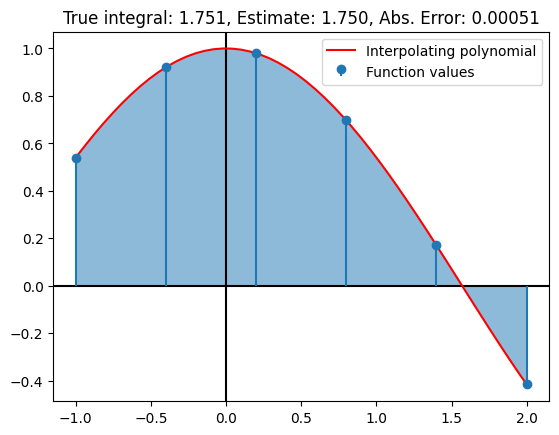

In [68]:
n = 5
weights   = ClosedNewtonCotesWeights[n]
print("Using the rule: ", ClosedNewtonCotesNames[n], 'with weights ', weights )
nodes,h = np.linspace(a,b,n+1,retstep=True) # retstep tells it to return the spacing h

I_n = h*np.dot( weights, f(nodes) )
p   = interp(nodes,f(nodes))

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');
plt.plot( x, p(x), 'r-', label="Interpolating polynomial" )
plt.stem( nodes, f(nodes), basefmt=' ', label="Function values" )
print(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.title(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.legend()
plt.show()

In [69]:
p = P.fit(nodes,f(nodes),deg=n) # interpolation (really, least-squares, but 0 residual since degree is large enough)
antideriv = p.integ(lbnd=a)
antideriv(b),  I_n

(np.float64(1.750257589002645), np.float64(1.7502575890026433))

### $n=6$

Using the rule:  n=6 with weights  [0.29285714285714287, 1.542857142857143, 0.19285714285714287, 1.9428571428571428, 0.19285714285714287, 1.542857142857143, 0.29285714285714287]
True integral: 1.751, Estimate: 1.751, Abs. Error: 0.00001


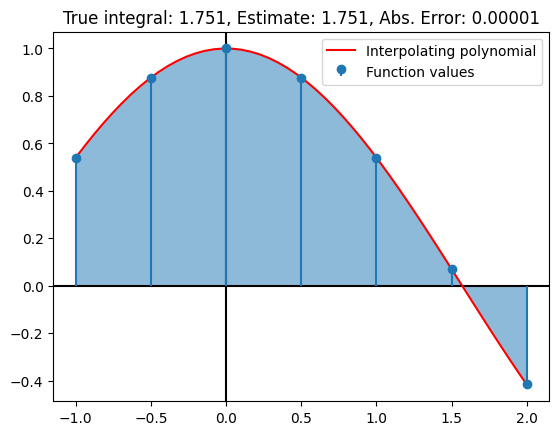

In [70]:
n = 6
weights   = ClosedNewtonCotesWeights[n]
print("Using the rule: ", ClosedNewtonCotesNames[n], 'with weights ', weights )
nodes,h = np.linspace(a,b,n+1,retstep=True) # retstep tells it to return the spacing h

I_n = h*np.dot( weights, f(nodes) )
p   = interp(nodes,f(nodes))

x = np.linspace(a,b)
plt.fill_between( x, f(x), alpha=0.5);
plt.axvline(color='k');
plt.axhline(color='k');
plt.plot( x, p(x), 'r-', label="Interpolating polynomial" )
plt.stem( nodes, f(nodes), basefmt=' ', label="Function values" )
print(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.title(f"True integral: {I:.3f}, Estimate: {I_n:.3f}, Abs. Error: {abs(I-I_n):.5f}")
plt.legend()
plt.show()

In [71]:
p = P.fit(nodes,f(nodes),deg=n) # interpolation (really, least-squares, but 0 residual since degree is large enough)
antideriv = p.integ(lbnd=a)
antideriv(b),  I_n

(np.float64(1.7507787937975943), np.float64(1.7507787937975945))

## Let's try different kinds of functions

In [40]:
def tryAllRules( f, F, a, b):
  err = []
  for n in range(1,6+1):
    weights   = ClosedNewtonCotesWeights[n]
    nodes,h = np.linspace(a,b,n+1,retstep=True)
    I_estimate = h*np.dot( weights, f(nodes) )
    I   = F(b) - F(a) # True answer
    err.append( abs(I_estimate - I))
  return np.array( err )

f_names= []

f = lambda x : np.cos(x)
F = lambda x : np.sin(x)  # dF/dx = f
f_names.append(r'$\cos(x)$')
a,b = -1,2
err1 = tryAllRules( f, F, a, b)

# Other examples to try
f = lambda x : x**(3/2)
F = lambda x : 2/5*x**(5/2)
f_names.append(r'$x^{3/2}$')
a,b = 0,1
err2 = tryAllRules( f, F, a, b)

f = lambda x : x**(11/2)
F = lambda x : 2/13*x**(5/13)
f_names.append(r'$x^{11/2}$')
a,b = 0,1
err3 = tryAllRules( f, F, a, b)

# Runge's function
f = lambda x : 1/(1+x**2)
F = lambda x : np.arctan(x)
f_names.append(r'$1/(1+x^2)$')
a,b = -5,5
err4 = tryAllRules( f, F, a, b)

AllErrors = np.array([err1,err2,err3,err4]).T

print("Rows are different n, columns are different functions")
with np.printoptions(precision=2, suppress=False):
  print(AllErrors)
# print(np.array2string( AllErrors, precision=2)) # another way

Rows are different n, columns are different functions
[[1.56e+00 1.00e-01 3.46e-01 2.36e+00]
 [6.65e-02 2.37e-03 2.76e-02 4.05e+00]
 [2.86e-02 1.29e-03 1.24e-02 6.65e-01]
 [9.15e-04 3.03e-04 1.22e-04 3.73e-01]
 [5.11e-04 2.11e-04 6.92e-05 4.39e-01]
 [1.04e-05 8.73e-05 5.90e-07 1.12e+00]]


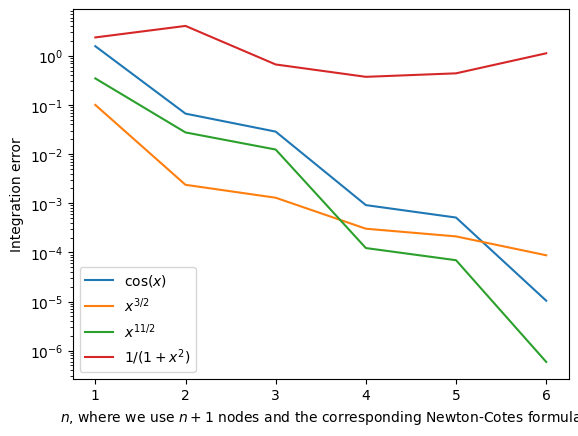

In [44]:
plt.semilogy( range(1,6+1),AllErrors, label=f_names )
plt.ylabel('Integration error')
plt.xlabel('$n$, where we use $n+1$ nodes and the corresponding Newton-Cotes formula')
plt.legend()
plt.show()

### Let's examine Runge's function more closely
$$f(x) = \frac{1}{1+x^2}$$

Our error wasn't going down, but the function is $C^\infty(\mathbb{R})$. Did we make a mistake?

No, our formula was correct, the issue is that the $f'(\xi)$ term (and $f''(\xi)$, etc.) are very large.  One way to think of this issue is that the function has a **singularity** (though it is on the imaginary axis, at $\pm i$).

(Btw, how do you prounce Runge? It's German, and you can listen to native speakers say it [at Forvo](https://forvo.com/search/Runge/))

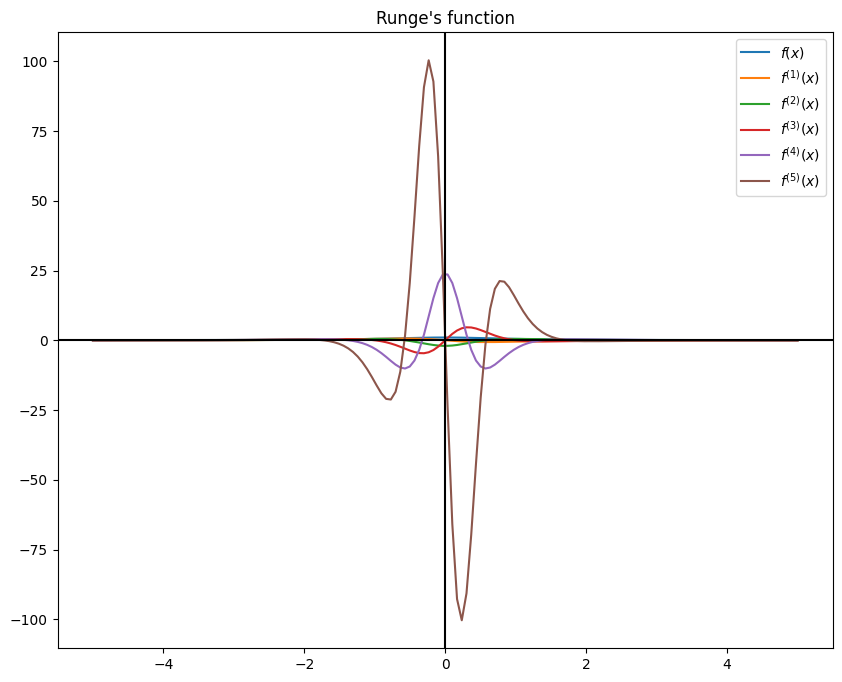

In [45]:
import sympy
from sympy.abc import x
from sympy import init_printing
from sympy.utilities.lambdify import lambdify

f = lambda x : 1/(1+x**2)
F = lambda x : np.arctan(x)
a,b = -5,5

g = 1/(1+x**2) # symbolic version

gNumerical = lambdify(x,g) # avoid sympy plotting
xGrid   = np.linspace(a,b,150)
plt.figure(figsize=(10,8))
plt.plot( xGrid, gNumerical(xGrid),label='$f(x)$' )


for k in range(1,6):
  dg = lambdify(x,sympy.diff(g,x,k))
  plt.plot( xGrid, dg(xGrid), label="$f^{("+str(k)+")}(x)$");
plt.axvline(color='k')
plt.axhline(color='k')
plt.legend()
plt.title("Runge's function")